In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('apple.csv')
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,01/02/2025,$243.85,55740730,$248.93,$249.10,$241.8201
1,12/31/2024,$250.42,39480720,$252.44,$253.28,$249.43
2,12/30/2024,$252.20,35557540,$252.23,$253.50,$250.75
3,12/27/2024,$255.59,42355320,$257.83,$258.70,$253.06
4,12/26/2024,$259.02,27262980,$258.19,$260.10,$257.63


In [ ]:
# Only want Date and Closing price
df = df[['Date', 'Close/Last']]
df.head()

,Date,Close/Last
0,01/02/2025,$243.85
1,12/31/2024,$250.42
2,12/30/2024,$252.20
3,12/27/2024,$255.59
4,12/26/2024,$259.02


In [ ]:
def str_to_datetime(s):
  split = s.split('/')
  month, day, year = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')
df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)
df.head()

,Close/Last
Date,
2025-01-02,243.85
2024-12-31,250.42
2024-12-30,252.20
2024-12-27,255.59
2024-12-26,259.02


In [ ]:
df.sort_index(inplace=True)
df.head()

,Close/Last
Date,
2015-01-05,26.5625
2015-01-06,26.5650
2015-01-07,26.9375
2015-01-08,27.9725
2015-01-09,28.0025


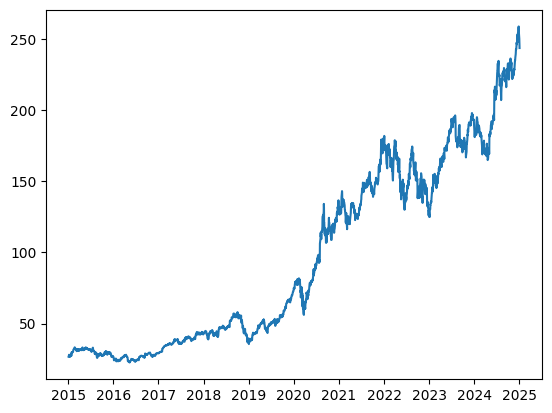

In [ ]:
import matplotlib.ticker as ticker

plt.plot(df.index, df['Close/Last'])
plt.show()

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close/Last'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Initalise start date
windowed_df = df_to_windowed_df(df,
                                '01/01/2016', # start date
                                '01/02/2025', # end date
                                n=3) # target window
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2016-01-01,26.7050,27.1850,26.8300,26.3150
1,2016-01-05,26.8300,26.3150,26.3375,25.6775
2,2016-01-06,26.3150,26.3375,25.6775,25.1750
3,2016-01-07,26.3375,25.6775,25.1750,24.1125
4,2016-01-08,25.6775,25.1750,24.1125,24.2400
...,...,...,...,...,...
2260,2024-12-26,254.4900,255.2700,258.2000,259.0200
2261,2024-12-27,255.2700,258.2000,259.0200,255.5900
2262,2024-12-30,258.2000,259.0200,255.5900,252.2000
2263,2024-12-31,259.0200,255.5900,252.2000,250.4200


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2265,), (2265, 3, 1), (2265,))

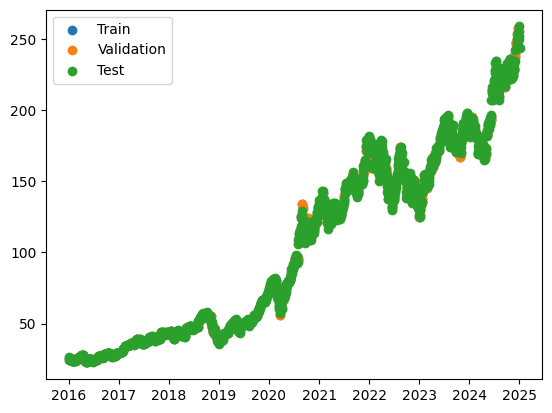

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

# 80% training data
dates_train, dates_val, X_train, X_val, y_train, y_val = train_test_split(dates, X, y, test_size=0.8, random_state=1)
# 10% validation data
dates_val, dates_test, X_val, X_test, y_val, y_test = train_test_split(dates, X, y, test_size=0.8, random_state=1)
# 10% test data

plt.scatter(dates_train, y_train)
plt.scatter(dates_val, y_val)
plt.scatter(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
import torch
import torch.nn as nn

In [ ]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([453, 3, 1]),
 torch.Size([1812, 3, 1]),
 torch.Size([453, 3, 1]),
 torch.Size([453]),
 torch.Size([453]),
 torch.Size([1812]))

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to('cpu'), batch[1].to('cpu')
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 3, 1]) torch.Size([32])


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Fully connected layer to output one value

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = LSTM()
model.to('cpu')
model

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
input_size = X_train.shape[2]
model = LSTM(input_size=input_size).to('cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training Loop
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            val_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

# --- Testing ---
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to('cpu')
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to('cpu')

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze().cpu().numpy()

print(predictions)

Epoch [1/200], Train Loss: 15125.6994, Val Loss: 12731.9438
Epoch [2/200], Train Loss: 12651.4449, Val Loss: 10994.4244
Epoch [3/200], Train Loss: 10564.9936, Val Loss: 9532.8484
Epoch [4/200], Train Loss: 9499.6232, Val Loss: 8342.9829
Epoch [5/200], Train Loss: 8056.7954, Val Loss: 7357.1568
Epoch [6/200], Train Loss: 7027.9000, Val Loss: 6588.7674
Epoch [7/200], Train Loss: 6578.3250, Val Loss: 5997.0009
Epoch [8/200], Train Loss: 6015.5336, Val Loss: 5519.0200
Epoch [9/200], Train Loss: 5669.4503, Val Loss: 5142.5049
Epoch [10/200], Train Loss: 5640.2730, Val Loss: 4862.2679
Epoch [11/200], Train Loss: 4922.8444, Val Loss: 4654.3811
Epoch [12/200], Train Loss: 4822.5826, Val Loss: 4507.4658
Epoch [13/200], Train Loss: 4631.4517, Val Loss: 4408.4400
Epoch [14/200], Train Loss: 4401.9196, Val Loss: 4339.1996
Epoch [15/200], Train Loss: 4447.0176, Val Loss: 4293.3465
Epoch [16/200], Train Loss: 4350.8402, Val Loss: 4264.1422
Epoch [17/200], Train Loss: 4533.5983, Val Loss: 4243.8339
E

C:\Users\lifro\AppData\Local\Temp\ipykernel_7844\3327971127.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to('cpu')
C:\Users\lifro\AppData\Local\Temp\ipykernel_7844\3327971127.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to('cpu')


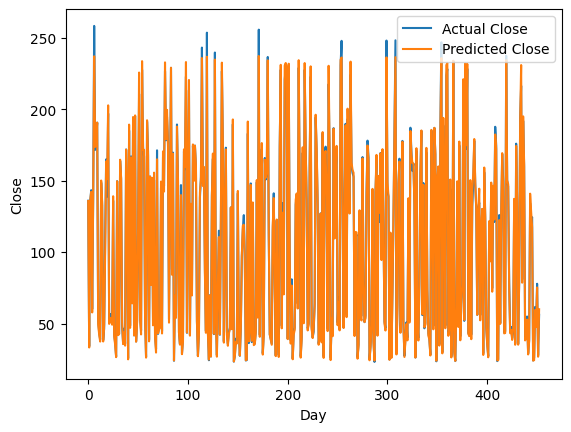

In [ ]:
model.eval()
with torch.no_grad():
    predicted = model(X_train.to('cpu')).numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

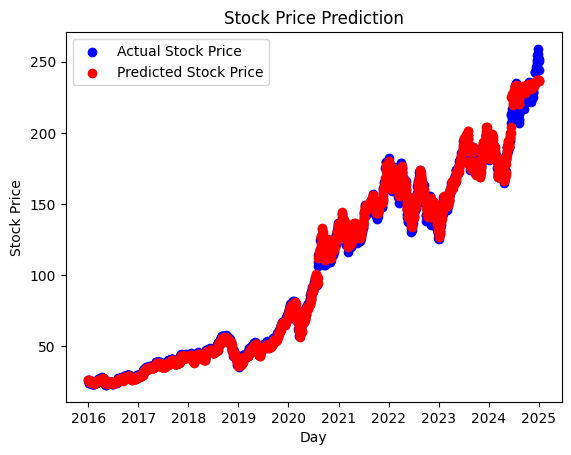

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

plt.scatter(dates_test,actual, label='Actual Stock Price', color='b')
plt.scatter(dates_test, predictions, label='Predicted Stock Price', color='r')
plt.title('Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.legend()
plt.show()